In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
d=500
B=12
A = np.random.normal(size=[B,d])
A.shape

(12, 500)

In [12]:
K = np.eye(d)

In [14]:
np.dot(A,K).shape

(12, 500)

In [25]:
def generate_data(d, B, K):
    """
    Generate data from multivariate normal distribution
    Args:
        d (int): dimension
        B (int): block size
        K (np.ndarray): d x d covariance matrix
    """
    return np.random.multivariate_normal(np.zeros(d), K, size=B)

def generate_data_rootK(d, B, rootK):
    """
    Generate data from multivariate normal distribution
    Args:
        d (int): dimension
        B (int): block size
        rootK (np.ndarray): sqrt of d x d covariance matrix
    """
    return np.dot(np.random.normal(size=[B,d]),rootK)


def compute_loss(theta, beta, K):
    """
    Compute loss P(theta) = <K(theta - beta), theta - beta>
    """
    diff = theta - beta
    return np.dot(diff, K @ diff)

def block_kaczmarz(d, B, m, K):
    """
    Implement block Kaczmarz algorithm
    Args:
        d (int): dimension
        B (int): block size
        m (int): number of iterations
        K (np.ndarray): d x d covariance matrix
    """
    # Initialize parameters
    theta = np.zeros(d)
    beta = np.random.normal(0, 1/np.sqrt(d), size=d)

    rootK =np.linalg.cholesky(K)
    
    # Store loss/norm history
    loss_history = np.zeros(m)
    norm_history = np.zeros(m)

    
    for r in range(m):
        # Generate new block of data
        X_r = generate_data_rootK(d, B, rootK)
        
        # Compute operator norm (for this simple case, it's the largest singular value)
        op_norm_squared = np.linalg.norm(X_r, ord=2)**2
        
        # Compute the update term
        update = np.zeros(d)
        for i in range(B):
            x_i = X_r[i]
            update += x_i * np.dot(x_i, theta - beta)
        
        # Update theta
        theta = theta - (1/op_norm_squared) * update
        
        # Compute and store loss
        loss_history[r] = compute_loss(theta, beta, K)
        norm_history[r] = op_norm_squared
    
    return loss_history, norm_history


In [55]:
def compute_volterra_prediction(d, B, num_iterations, K, gamma=None):
    """
    Compute the Volterra prediction by solving the forward difference equations
    """
    if gamma is None:
        gamma = 1/((np.sqrt(B) + np.sqrt(d))**2)  # Use same step size as before
    
    # Get eigenvalues of K
    lambdas = np.linalg.eigvalsh(K)
    
    # Initialize rho^2 values
    rho_squared = np.ones(d) / d
    
    # Store the prediction values
    predictions = np.zeros(num_iterations)
    
    # Compute initial prediction
    predictions[0] = np.sum(lambdas * rho_squared)
    
    # Solve forward difference equations
    for r in range(1, num_iterations):
        # Current P value (needed for the update)
        current_P = predictions[r-1]
        
        # Update each rho_j^2
        delta_rho = np.zeros(d)
        for j in range(d):
            delta_rho[j] = (-2 * gamma * B * lambdas[j] + 2 * gamma**2 * B**2 * lambdas[j]**2) * rho_squared[j] + \
                          gamma**2 * B * lambdas[j] * current_P
        
        # Update rho_squared values
        rho_squared += delta_rho
        
        # Compute prediction for this iteration
        predictions[r] = np.sum(lambdas * rho_squared)
    
    return predictions

In [18]:
def compute_theoretical_KId_curve(d, B, num_iterations):
    """
    Compute theoretical expected loss curve
    Args:
        d (int): dimension
        B (int): block size
        num_iterations (int): number of iterations
    """
    # Compute eta
    eta = 1 / ((np.sqrt(B) + np.sqrt(d))**2)
    
    # Compute m
    m = 1 - 2*eta*B + 2*(eta**2)*(B**2)
    
    # Compute the base for exponential
    base = m + (eta**2)*(B*d)
    
    # Generate curve
    curve = np.array([base**r for r in range(num_iterations)])
    
    return curve

The following is the basic identity covariance comparison

Identity covariance expereiments

In [26]:
# Run experiment
d = 500
m = 500 // 16  # number of iterations
block_sizes = [1, 2, 4, 8, 16]

# Create identity matrix for K
K = np.eye(d)

# Run algorithm for different block sizes and store results
results = {}
for B in tqdm(block_sizes):
    results[B], _ = block_kaczmarz(d, B, m, K)


100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


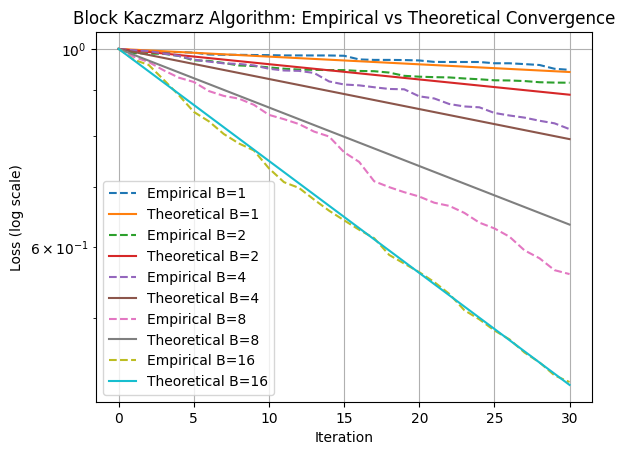

In [20]:
for B in block_sizes:
    # Empirical results
    plt.semilogy(results[B]/results[B][0], '--', label=f'Empirical B={B}')
    
    # Theoretical curve
    theoretical_loss = compute_theoretical_KId_curve(d, B, m)
    plt.semilogy(theoretical_loss, '-', label=f'Theoretical B={B}')

plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Block Kaczmarz Algorithm: Empirical vs Theoretical Convergence')
plt.legend()
plt.grid(True)
plt.savefig('KaczmarzId.pdf')

Confirm that Volterra matches the explicitly solvable theory

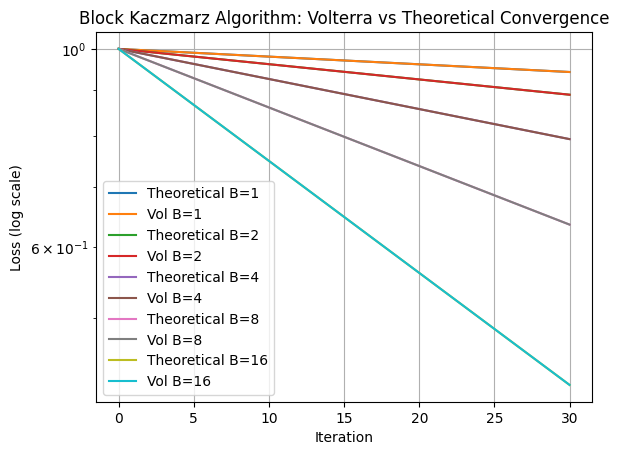

In [21]:
for B in block_sizes:
    # Theoretical curve
    theoretical_loss = compute_theoretical_KId_curve(d, B, m)
    plt.semilogy(theoretical_loss, '-', label=f'Theoretical B={B}')
    
    # Volterra curve
    volterra_loss = compute_volterra_prediction(d, B, m, K)
    plt.semilogy(theoretical_loss, '-', label=f'Vol B={B}')

plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Block Kaczmarz Algorithm: Volterra vs Theoretical Convergence')
plt.legend()
plt.grid(True)

Non-identity Covariance with spectral gap.

In [22]:
def k_generate_eigenvalues(d, kappa):
    """
    Generate eigenvalues according to f(x) = 1/(1-(1-1/kappa)x)
    """
    x = np.linspace(0, 1, d)
    return 1/(1-(1-1/kappa)*x)

def k_chevet_step_size(B, d, kappa):
    """
    Compute Chevet approximate step size
    """
    numerator = 1
    denominator = (np.sqrt(B*kappa) + np.sqrt(d * np.log(kappa)/(1-1/kappa)))**2
    return numerator/denominator

In [60]:
# Set up parameters
d = 500
m = 500 // 16
block_sizes = [1, 2, 4, 8, 16]
kappa = 10

# Generate eigenvalues and create diagonal K matrix
eigenvalues = k_generate_eigenvalues(d, kappa)
K = np.diag(eigenvalues)

k_results = {}
k_norms ={}
k_volterra = {}

for B in tqdm(block_sizes):
    # Compute Chevet step size for this block size
    gamma = k_chevet_step_size(B, d, kappa)
    
    # Run empirical simulation
    k_results[B],k_norms[B] = block_kaczmarz(d, B, m, K)
    #plt.semilogy(empirical_loss, '--', color=colors[idx], label=f'Empirical B={B}')
    
    # Compute Volterra prediction with Chevet step size
    k_volterra[B] = compute_volterra_prediction(d, B, m, K, gamma)
    #plt.semilogy(volterra_loss, ':', color=colors[idx], label=f'Volterra B={B} (Chevet)')


100%|██████████| 5/5 [00:34<00:00,  6.82s/it]


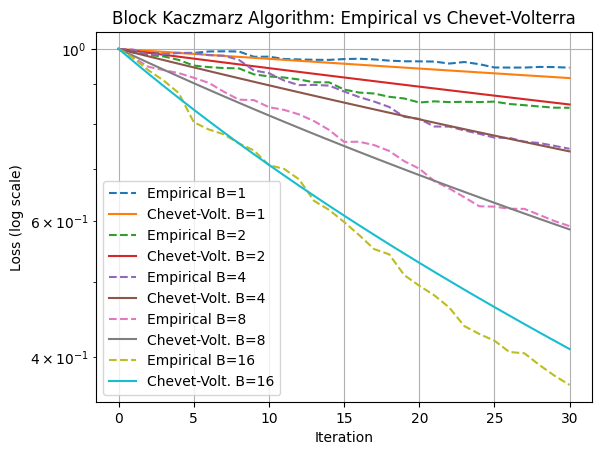

In [61]:
for B in block_sizes:
    # Empirical results
    plt.semilogy(k_results[B]/k_results[B][0], '--', label=f'Empirical B={B}')
    
    # Theoretical curve
    plt.semilogy(k_volterra[B]/k_volterra[B][0], '-', label=f'Chevet-Volt. B={B}')

plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Block Kaczmarz Algorithm: Empirical vs Chevet-Volterra')
plt.legend()
plt.grid(True)
plt.savefig('Kaczmarz_Kgap.pdf')


Block Size B=1:
Chevet stepsize: 6.60e-04
Mean empirical stepsize: 7.92e-04
Median empirical stepsize: 7.89e-04
Std empirical stepsize: 7.28e-05

Block Size B=2:
Chevet stepsize: 6.18e-04
Mean empirical stepsize: 7.32e-04
Median empirical stepsize: 7.30e-04
Std empirical stepsize: 3.88e-05

Block Size B=4:
Chevet stepsize: 5.64e-04
Mean empirical stepsize: 6.84e-04
Median empirical stepsize: 6.86e-04
Std empirical stepsize: 3.29e-05

Block Size B=8:
Chevet stepsize: 5.00e-04
Mean empirical stepsize: 6.17e-04
Median empirical stepsize: 6.15e-04
Std empirical stepsize: 2.92e-05

Block Size B=16:
Chevet stepsize: 4.27e-04
Mean empirical stepsize: 5.50e-04
Median empirical stepsize: 5.47e-04
Std empirical stepsize: 2.48e-05


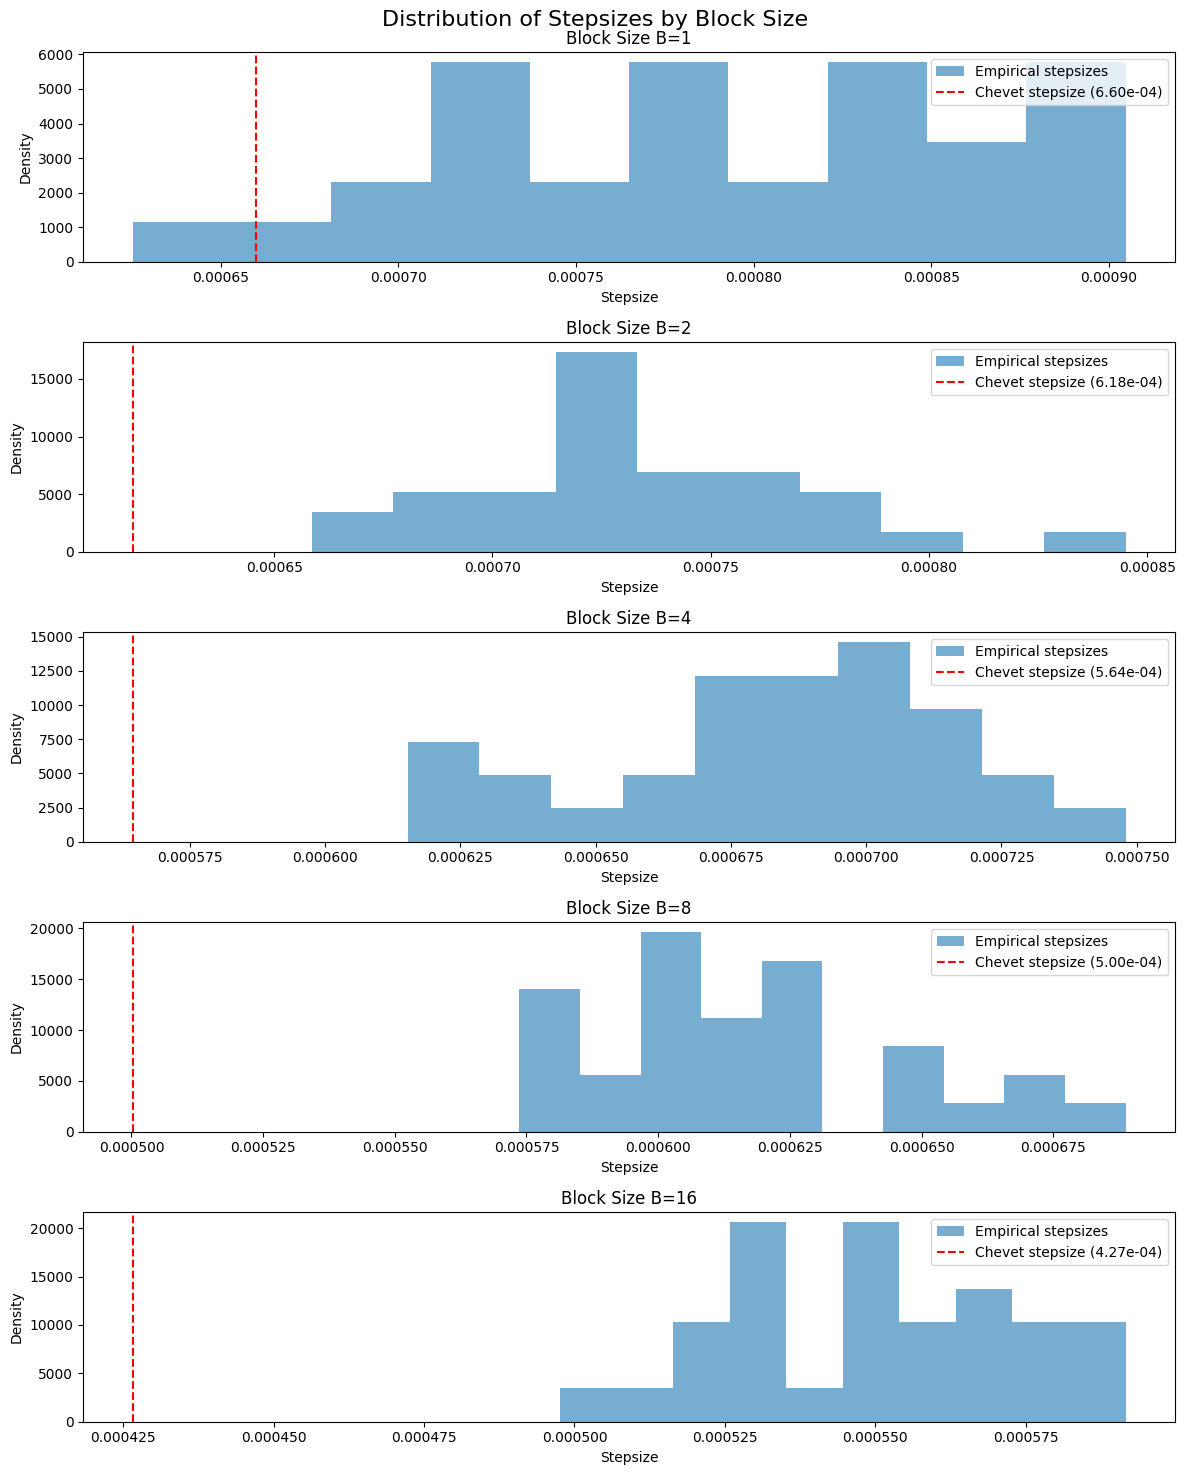

In [63]:
# Create figure with subplots for each block size
fig, axes = plt.subplots(len(block_sizes), 1, figsize=(12, 3*len(block_sizes)))
fig.suptitle('Distribution of Stepsizes by Block Size', fontsize=16)

for idx, B in enumerate(block_sizes):
    ax = axes[idx]
    
    # Get empirical stepsizes (reciprocal of k_norms)
    empirical_stepsizes = 1/np.array(k_norms[B])
    
    # Compute Chevet stepsize for this B
    chevet_step = k_chevet_step_size(B, d, kappa)
    
    # Create histogram of empirical stepsizes
    ax.hist(empirical_stepsizes, bins=10, alpha=0.6, density=True, 
            label='Empirical stepsizes')
    
    # Add vertical line for Chevet stepsize
    ax.axvline(x=chevet_step, color='red', linestyle='--', 
               label=f'Chevet stepsize ({chevet_step:.2e})')
    
    # Add labels and legend
    ax.set_xlabel('Stepsize')
    ax.set_ylabel('Density')
    ax.set_title(f'Block Size B={B}')
    ax.legend()
    
    # Print statistics
    print(f"\nBlock Size B={B}:")
    print(f"Chevet stepsize: {chevet_step:.2e}")
    print(f"Mean empirical stepsize: {np.mean(empirical_stepsizes):.2e}")
    print(f"Median empirical stepsize: {np.median(empirical_stepsizes):.2e}")
    print(f"Std empirical stepsize: {np.std(empirical_stepsizes):.2e}")

plt.tight_layout()
plt.savefig('Kgap_stepsize_comparison.pdf')


Use empirical eta-s

In [64]:
k_emp_volterra = {}

for B in tqdm(block_sizes):
    # Compute Chevet step size for this block size
    gamma = 1/np.mean(np.array(k_norms[B]))
    
    # Compute Volterra prediction with Chevet step size
    k_emp_volterra[B] = compute_volterra_prediction(d, B, m, K, gamma)
    #plt.semilogy(volterra_loss, ':', color=colors[idx], label=f'Volterra B={B} (Chevet)')


100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


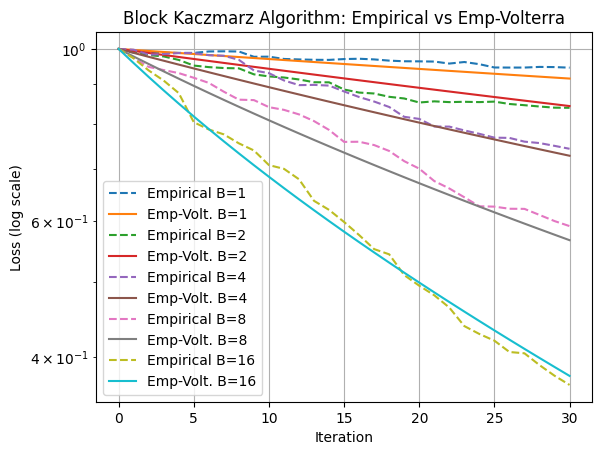

In [66]:
for B in block_sizes:
    # Empirical results
    plt.semilogy(k_results[B]/k_results[B][0], '--', label=f'Empirical B={B}')
    
    # Theoretical curve
    plt.semilogy(k_emp_volterra[B]/k_emp_volterra[B][0], '-', label=f'Emp-Volt. B={B}')

plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Block Kaczmarz Algorithm: Empirical vs Emp-Volterra')
plt.legend()
plt.grid(True)
plt.savefig('Kaczmarz_Kgap_empVolt.pdf')